<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
import sys


sys.path.append("..")

<a id='1.3'></a>
## 2.3. Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

/opt/conda/lib/python3.6/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='1.4'></a>
## 2.4. Create Folders

In [3]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [4]:
# from config.py start_date is a string
config.START_DATE = "2018-01-01"

In [5]:
# from config.py end_date is a string
config.END_DATE
print(f"start: {config.START_DATE}, end: {config.END_DATE}")

start: 2018-01-01, end: 2020-12-01


In [6]:
pprint(config.DOW_30_TICKER)

['AAPL',
 'MSFT',
 'JPM',
 'V',
 'RTX',
 'PG',
 'GS',
 'NKE',
 'DIS',
 'AXP',
 'HD',
 'INTC',
 'WMT',
 'IBM',
 'MRK',
 'UNH',
 'KO',
 'CAT',
 'TRV',
 'JNJ',
 'CVX',
 'MCD',
 'VZ',
 'CSCO',
 'XOM',
 'BA',
 'MMM',
 'PFE',
 'WBA',
 'DD']


In [7]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [8]:
df.shape

(22020, 7)

In [9]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL
1,2018-01-02,99.730003,99.730003,98.220001,94.424980,2746700,AXP
2,2018-01-02,295.750000,296.989990,295.399994,282.886383,2978900,BA
3,2018-01-02,158.300003,159.389999,156.029999,145.002594,5108400,CAT
4,2018-01-02,38.669998,38.950001,38.430000,35.173683,20135700,CSCO


In [10]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)


processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [11]:
print(type(processed))

<class 'pandas.core.frame.DataFrame'>


In [12]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL,0.0,0.0,66.666667,100.0,0.0
1,2018-01-02,99.730003,99.730003,98.220001,94.424980,2746700,AXP,0.0,0.0,66.666667,100.0,0.0
2,2018-01-02,295.750000,296.989990,295.399994,282.886383,2978900,BA,0.0,0.0,66.666667,100.0,0.0
3,2018-01-02,158.300003,159.389999,156.029999,145.002594,5108400,CAT,0.0,0.0,66.666667,100.0,0.0
4,2018-01-02,38.669998,38.950001,38.430000,35.173683,20135700,CSCO,0.0,0.0,66.666667,100.0,0.0
5,2018-01-02,125.709999,127.739998,125.540001,111.714676,5626000,CVX,0.0,0.0,66.666667,100.0,0.0
6,2018-01-02,101.863419,102.745842,101.621460,92.456123,5220700,DD,0.0,0.0,66.666667,100.0,0.0
7,2018-01-02,108.949997,111.809998,108.559998,108.726067,11014300,DIS,0.0,0.0,66.666667,100.0,0.0
8,2018-01-02,257.769989,257.910004,253.919998,241.290482,2258300,GS,0.0,0.0,66.666667,100.0,0.0
9,2018-01-02,190.210007,190.720001,188.009995,174.873688,4684700,HD,0.0,0.0,66.666667,100.0,0.0


In [13]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2020-12-01')
print(len(train))
print(len(trade))


7530
14490


In [14]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,99.730003,99.730003,98.220001,94.424980,2746700,AXP,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,295.750000,296.989990,295.399994,282.886383,2978900,BA,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,158.300003,159.389999,156.029999,145.002594,5108400,CAT,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,38.669998,38.950001,38.430000,35.173683,20135700,CSCO,0.0,0.0,66.666667,100.0,0.0


In [15]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.562561,148158800,AAPL,-2.019903,37.865996,-91.567852,42.250809,0.0
0,2019-01-02,93.910004,96.269997,93.769997,92.643311,4175400,AXP,-3.426008,41.203529,-97.742269,26.709418,0.0
0,2019-01-02,316.190002,323.950012,313.709991,314.645142,3292200,BA,-5.550593,47.008584,-21.712382,13.611972,0.0
0,2019-01-02,124.029999,127.879997,123.000000,119.302582,4783200,CAT,-0.686759,48.226579,-5.091209,0.873480,0.0
0,2019-01-02,42.279999,43.200001,42.209999,40.057236,23833500,CSCO,-0.952338,44.871084,-87.518839,29.529378,0.0


In [16]:
dates = trade.date.sort_values().unique()
print(dates.dtype)

object


In [17]:
tr = trade.set_index("date")
print(tr.index.dtype)
sel = tr.loc['2020-11-20']
subsel = sel[sel.tic=='AAPL']
subsel.head()


object


,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
date,,,,,,,,,,,
2020-11-20,118.639999,118.769997,117.290001,117.339996,73604300,AAPL,0.924229,52.396068,19.335836,6.844827,11.837987


In [18]:
subsel.loc['2020-11-20', ['open', 'close']].tolist()

[118.63999938964844, 117.33999633789062]

In [19]:
v = []
v+=(subsel.loc['2020-11-20', ['open', 'close']].tolist())
print(v)

[118.63999938964844, 117.33999633789062]


In [20]:
a = np.arange(50)
print(len(a[1:31]))

30


In [21]:
a = np.random.randn(4)
b = np.random.rand(4)
print(a)
print(b)

[-0.24508717  1.75589316 -2.2838474   0.61864901]
[0.89623596 0.49025325 0.01673557 0.91447935]


In [22]:
actions = np.array([-5, 5, -5])
holdings = np.array([10, 15, 0])
expected = np.array([-5, 5, -3])


min_actions = -holdings
print(min_actions)

final_actions = np.maximum(actions, min_actions)
print(final_actions)

[-10 -15   0]
[-5  5  0]


In [23]:
np.dot(np.arange(10), np.arange(10))

285

In [24]:
np.arange(20)[::3]

array([ 0,  3,  6,  9, 12, 15, 18])

In [25]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from stable_baselines3.common.vec_env import DummyVecEnv

class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}
    
    
    '''
    state space: {start_cash, <owned_shares>, for s in stocks{<stock.values>}, }
    '''

    def __init__(self,df,
                 transaction_cost_pct=3e-3,
                 date_col_name = 'date',
                 hmax = 10,
                 turbulence_threshold=None,
                 make_plots = False, 
                print_verbosity = 10,
                 reward_scaling = 1e-4,
                 initial_amount = 1e6,
                 daily_information_cols = ['open', 'close', 'high', 'low', 'volume'],
                day = 0, iteration=''):
        self.df = df
        self.stock_col = 'tic'
        self.assets = df[self.stock_col].unique()
        self.dates = df[date_col_name].sort_values().unique()
        self.df = self.df.set_index(date_col_name)
        self.hmax = hmax
        self.initial_amount = initial_amount
        self.print_verbosity = print_verbosity
        self.transaction_cost_pct =transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.daily_information_cols = daily_information_cols
        self.close_index = self.daily_information_cols.index('close')
        self.state_space = 1+len(self.assets) + len(self.assets)*len(self.daily_information_cols) 
        self.action_space = spaces.Box(low = -1, high = 1,shape = (len(self.assets),)) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space,))
        self.episode = -1 # initialize so we can call reset
        self._seed()


        
    def get_date_vector(self, date, cols=None):
        date = self.dates[date]
        if cols is None:
            cols = self.daily_information_cols
        trunc_df = self.df.loc[date]
        v = []
        for a in self.assets:
            subset = trunc_df[trunc_df[self.stock_col]==a]
            v+=subset.loc[date, cols].tolist()
        assert len(v)==len(self.assets)*len(cols)
        return v
    
    
    def step(self, actions):
        actions = actions*self.hmax
        # need to prevent selling assets we don't have
        self.actions_memory.append(actions)
        
        def return_terminal(reason = "hit end of the dates!"):
            print(reason)
            state = self.state_memory[-1]
            reward = self.account_information['total_assets'][-1]-self.account_information['total_assets'][0]
            return state, reward*self.reward_scaling, True, {}
            
        #terminal case
        if self.date_index+1%self.print_verbosity==0:
            print(f" date index: {self.date_index} of {len(self.dates)}")
            print(f"assets: {self.account_information['total_assets'][-1]:0.2f}")
        if self.date_index==len(self.dates)-1:
            return return_terminal()
        else:
            begin_cash = self.state_memory[-1][0]
            holdings = self.state_memory[-1][1:len(self.assets)+1]
            closings = np.array(self.get_date_vector(self.date_index, cols = ['close']))
            asset_value = np.dot(holdings,closings)
            reward = begin_cash + asset_value - self.account_information['total_assets'][-1]
            self.account_information['cash'].append(begin_cash)
            self.account_information['asset_value'].append(asset_value)
            self.account_information['total_assets'].append(begin_cash + asset_value)
            actions = np.maximum(actions, -np.array(holdings))
            sells = -np.clip(actions, -np.inf, 0)
            proceeds = np.dot(sells,closings)
            costs = proceeds*self.transaction_cost_pct
            coh = begin_cash+proceeds
            buys = np.clip(actions,0, np.inf)
            spend = np.dot(buys, closings)
            costs += spend*self.transaction_cost_pct
            if (spend+costs)>coh:
                return return_terminal(f"ran out of cash at step: {self.date_index}, spend: {spend:0.2f}, costs: {costs:0.2f}, coh: {coh:0.2f}")
            assert (spend+costs)<coh
            coh = coh-spend-costs
            holdings_updated =holdings+actions
#             print(f"holdings updated: {holdings_updated}")
#             print(begin_cash+asset_value)
#             raise Exception()
            assert min(holdings_updated)>=0
            self.date_index+=1
            state = [coh] + list(holdings_updated) + self.get_date_vector(self.date_index)
            self.state_memory.append(state)
            
            return state, reward*self.reward_scaling, False, {}
            
    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        print(type(e))
        obs = e.reset()
        return e, obs
    
    def _seed(self):
                # memorize all the total balance change
                # initialize reward
        self.reward = 0
        self.date_index=0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        self.episode +=1
        self.asset_memory = [self.initial_amount]
        self.rewards_memory = []
        self.actions_memory=[]
        self.state_memory = []
        self.account_information = {
            "cash": [self.initial_amount], 
            "asset_value": [0], 
            "total_assets": [self.initial_amount]
        }
        self.state_memory.append(np.array([self.initial_amount] + [0]*len(self.assets) + self.get_date_vector(self.date_index)))
#         print(self.state_memory)
        
        
    def reset(self):
        print("reset called")
        self._seed()
        return [0 for _ in range(self.state_space)]
            
            
            
     
            
                                    


e = StockTradingEnv(df = trade)
# e.get_date_vector('2020-11-20')

In [26]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 30, State Space: 181


In [27]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.003, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockTradingEnv(df = train, print_verbosity = 50)

e_trade_gym = StockTradingEnv(df = trade)

In [28]:


env_train, _ = e_train_gym.get_sb_env()


env_trade, obs_trade = e_trade_gym.get_sb_env()

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
reset called
<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
reset called


In [31]:
da = DRLAgent(env = env_train)

PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 64,
    "n_epochs": 300
}


TD3_PARAMS = {
    "batch_size": 250, 
    "buffer_size": 1000000, 
    "learning_rate": 0.001
}
    
SAC_PARAMS = {
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "batch_size": 2048,
    "ent_coef": "auto_0.1",
}

model = da.get_model("ppo", model_kwargs = PPO_PARAMS,verbose = 1)
# model  = da.get_model("td3", model_kwargs = TD3_PARAMS)
# model  = da.get_model("sac", model_kwargs = SAC_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64, 'n_epochs': 300}
Using cuda device


In [ ]:
# trained = model.learn(.train_model(model, 'sac_again', total_timesteps = 200000)
trained = model.learn(total_timesteps=200000, 
                      tb_log_name='ppo', 
                      log_interval = 100, 
                      n_eval_episodes = 15)

reset called
Logging to tensorboard_log/ppo/ppo_1
hit end of the dates!
reset called
hit end of the dates!
reset called
hit end of the dates!
reset called
hit end of the dates!
reset called


In [ ]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [ ]:
insample_turbulence.turbulence.describe()

In [ ]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)
print(f"Turb threshold {turbulence_threshold:0.2f}")

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [36]:

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

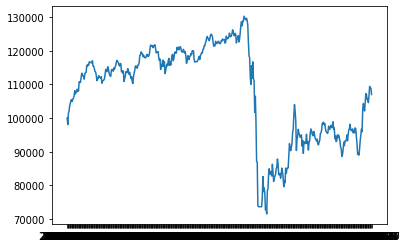

In [37]:
df_account_value.head()
plt.plot(df_account_value.date, df_account_value.account_value)

In [38]:
df_actions

,AAPL,AXP,BA,CAT,CSCO,CVX,DD,DIS,GS,HD,...,PFE,PG,RTX,TRV,UNH,V,VZ,WBA,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,58.287071,83.314850,-7.466996,15.962542,5.652583,-7.431322,-1.705885,90.499496,-64.217606,42.929554,...,-35.975109,-45.065575,5.812800,-24.161959,56.272781,-9.425074,1.702404,24.623669,-49.045952,24.937094
2019-01-03,25.249243,64.037178,90.765656,70.292816,30.451584,-24.761761,-90.083427,29.665363,56.398796,24.632418,...,7.584524,5.003154,21.916521,21.905327,58.819054,-13.870067,19.687187,49.940681,-76.403816,-70.066360
2019-01-04,-96.926025,-73.437271,40.944279,64.234009,99.739441,98.333649,27.031660,-98.042320,45.820236,-42.492359,...,95.502594,-91.355766,-52.905155,-50.692387,97.535156,69.414543,-67.492401,-98.890587,-91.253235,7.647812
2019-01-07,-11.762452,-39.998947,59.824623,-10.643673,94.700859,98.903725,-7.045901,-89.349640,18.755865,-71.215584,...,-51.138721,-69.811859,-86.397484,16.592957,98.135925,-51.699631,-81.504906,-98.067322,-97.943199,0.847208
2019-01-08,-41.285862,-43.479645,98.548035,-15.791506,99.805305,99.829697,34.720444,-96.653748,-6.743413,-2.290332,...,-91.205849,-74.829857,-92.027969,34.103321,98.736694,-85.270508,-77.737381,-99.524185,-99.303841,21.575153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,-13.098860,50.364719,99.976395,99.235428,-13.807768,60.433937,-99.931931,76.914871,97.223724,-99.986145,...,99.952408,-19.041306,-99.997864,97.531219,-99.908134,-49.987923,-99.772224,-98.178741,94.292450,-99.574997
2020-11-23,-46.477066,99.900032,99.965248,98.920807,-50.955296,7.750988,-99.949646,84.944275,99.816109,-99.999901,...,93.105316,44.810390,-99.991722,99.667107,-99.930359,-93.386353,-99.042717,-98.466995,93.712906,-99.832443
2020-11-24,4.346037,99.569084,99.995064,99.450066,-95.530945,58.902550,-99.987679,64.869118,97.494377,-99.999535,...,98.755135,-62.501614,-99.994102,99.719666,-99.982895,-67.256210,-99.945984,-93.813499,74.142120,-99.742355


In [39]:
df_account_value.shape

(483, 2)

In [40]:
df_account_value.head()

,date,account_value
0,2019-01-02,100000.000000
1,2019-01-03,98029.802163
2,2019-01-04,101494.557222
3,2019-01-07,102038.718858
4,2019-01-08,103730.379880


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [43]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  8.640802179488372
sharpe ratio:  0.271437091536778
Annual return          0.035911
Cumulative returns     0.069961
Annual volatility      0.305376
Sharpe ratio           0.271437
Calmar ratio           0.079624
Stability              0.319443
Max drawdown          -0.451006
Omega ratio            1.058735
Sortino ratio          0.356324
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.909565
Daily value at risk   -0.038145
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  8.640802179488372
sharpe ratio:  0.271437091536778
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)


Start date,2019-01-03
End date,2020-11-30
Total months,22
,Backtest
Annual return,3.599%
Cumulative returns,6.996%
Annual volatility,30.538%
Sharpe ratio,0.27
Calmar ratio,0.08
Stability,0.32
Max drawdown,-45.101%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,45.10,2020-02-12,2020-04-03,NaT,NaN
1,7.04,2019-07-23,2019-08-14,2019-11-13,82
2,5.89,2019-04-26,2019-06-03,2019-06-18,38
3,5.73,2019-03-01,2019-03-22,2019-04-26,41
4,3.09,2020-01-16,2020-01-27,2020-02-05,15


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


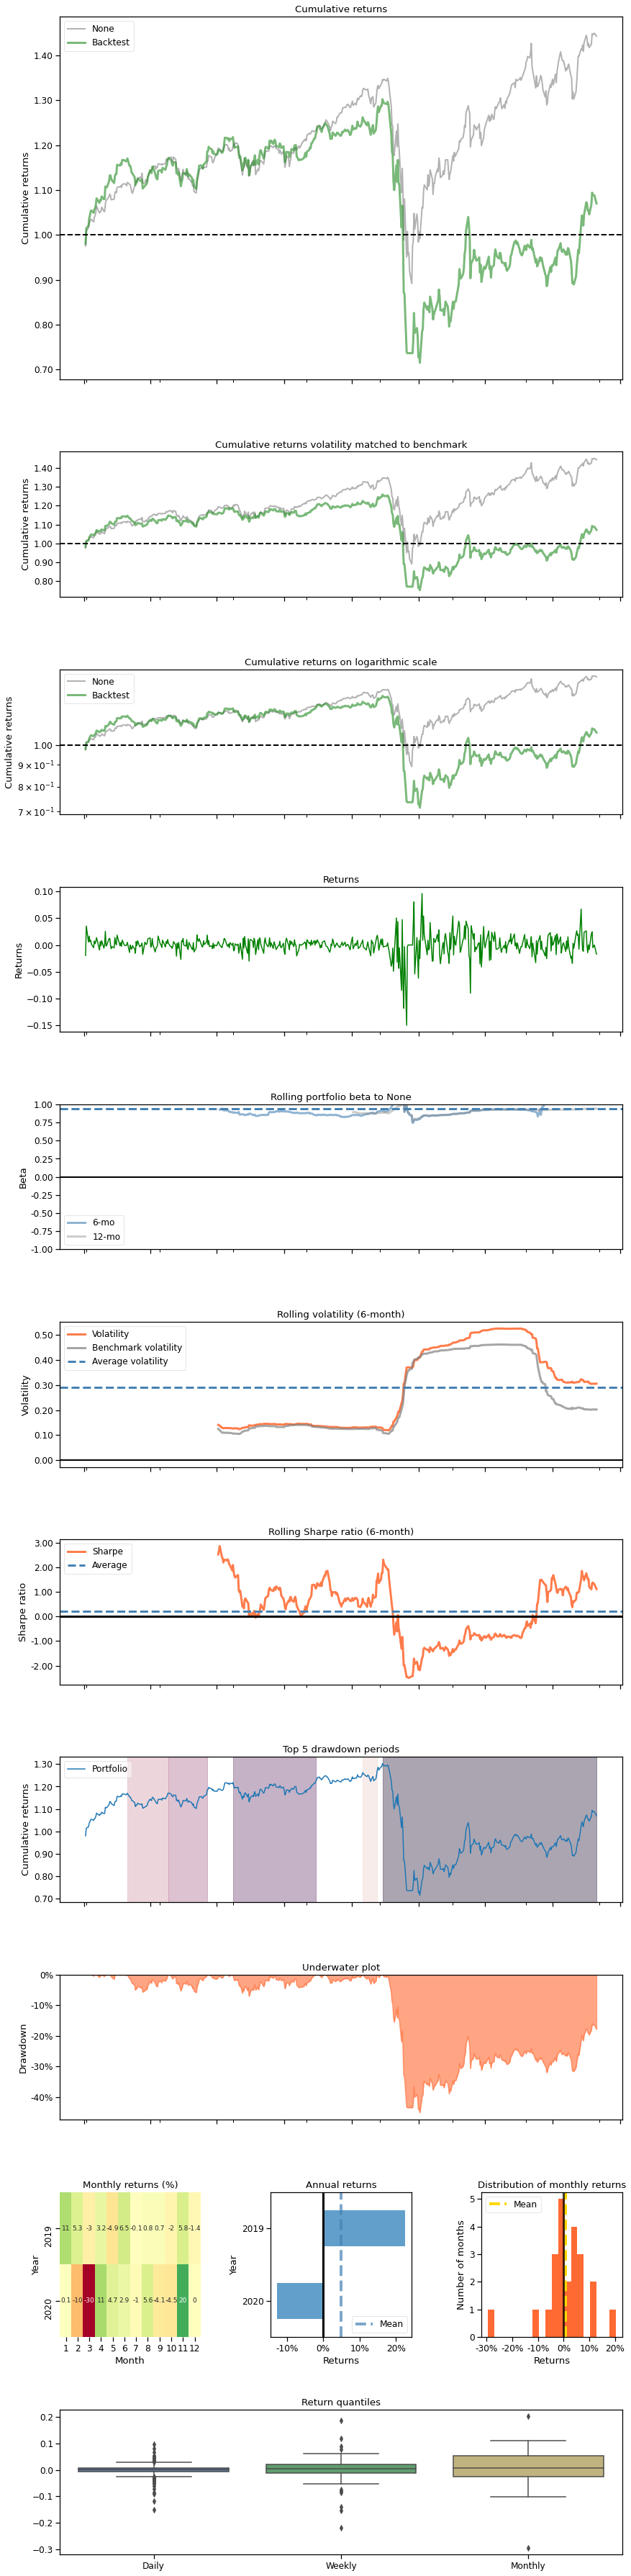

In [44]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^GSPC', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-12-01')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [45]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-12-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.132593
Cumulative returns     0.269525
Annual volatility      0.280347
Sharpe ratio           0.586312
Calmar ratio           0.357526
Stability              0.060828
Max drawdown          -0.370862
Omega ratio            1.137261
Sortino ratio          0.807330
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844803
Daily value at risk   -0.034668
Alpha                  0.000000
Beta                   1.000000
dtype: float64
